# Impact of 3.2 Beer in Kansas

In [1]:
# packages used
import pandas as pd
import numpy as np
from sklearn import cluster
from sklearn import metrics
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.preprocessing import MinMaxScaler
import matplotlib as mpl
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import scipy.stats as stats
import pylab as pl
%matplotlib inline
import Store
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)

### Load Data

In [2]:
#Stores Data
Stores = pd.read_csv('KansasStoreDataV1.csv')
#Stores Classification data
StoresClass = pd.read_csv('NonLowPointStoresKansasV1.csv', dtype = str)

In [3]:
Stores.head()

,STORE_CD,L12M_TY_QTY,PREMISE_TYPE_DSC,CHANNEL_DSC,SUBCHANNEL_DSC,FOOD_TYPE_GROUP_DSC,INDUSTRY_VOL_DSC,CHAIN_IND_FLG,FRANCHISE_FLG,BEER_FLG,...,MALE_POP_5564_PCT,MALE_POP_6574_PCT,MALE_POP_75_PCT,FEMALE_POP_2124_PCT,FEMALE_POP_2534_PCT,FEMALE_POP_3544_PCT,FEMALE_POP_4554_PCT,FEMALE_POP_5564_PCT,FEMALE_POP_6574_PCT,FEMALE_POP_75_PCT
0,102440246,NaN,ON PREMISE,DINING,FAST CASUAL,MEXICAN,UNKNOWN,Y,N,Y,...,0.0625,0.0386,0.0208,0.0248,0.0614,0.0677,0.0667,0.0683,0.0446,0.0307
1,102137482,NaN,ON PREMISE,BAR/NIGHTCLUB,NEIGHBORHOOD BAR,OTHER,UNKNOWN,N,N,Y,...,0.0620,0.0401,0.0252,0.0262,0.0769,0.0611,0.0572,0.0651,0.0462,0.0367
2,101739463,NaN,ON PREMISE,RECREATION,GOLF/COUNTRY CLUB,OTHER,UNKNOWN,N,N,Y,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,107507929,NaN,ON PREMISE,DINING,CASUAL DINING,ETHNIC,UNKNOWN,N,N,Y,...,0.0324,0.0225,0.0132,0.1070,0.0838,0.0494,0.0310,0.0362,0.0247,0.0199
4,103714966,NaN,ON PREMISE,DINING,CASUAL DINING,ASIAN,UNKNOWN,N,N,Y,...,0.0516,0.0299,0.0134,0.0235,0.0675,0.0774,0.0666,0.0552,0.0355,0.0212


#### Clean Data

In [4]:

#Remove Stores without Depletion data for the last year (NAs)
Stores = Stores.loc[Stores['L12M_TY_QTY'].notnull(),:]
print('Stores after removing stores with no depletion data ',len(Stores))

#Remove Stores with Negative Depletion data for the last year
Stores = Stores.loc[Stores['L12M_TY_QTY'] > 0,:] 
print('Stores after removing stores with negative ',len(Stores))

#Remove Stores without Demographic data (NAs)
Stores = Stores.loc[Stores['MALE_POP_5564_PCT'].notnull(),:]
print('Stores after removing stores with no demographic data ',len(Stores))

Stores = Stores.reset_index(drop=True)

#Change Y and N to 1 and 0
Stores['CHAIN_IND_FLG'] = Stores['CHAIN_IND_FLG']=='Y'
Stores['FRANCHISE_FLG'] = Stores['FRANCHISE_FLG']=='Y'
Stores['BEER_FLG'] = Stores['BEER_FLG']=='Y'
Stores['WINE_FLG'] = Stores['WINE_FLG']=='Y'
Stores['LIQUOR_FLG'] = Stores['LIQUOR_FLG']=='Y'
Stores['FINE_WINE_FLG'] = Stores['FINE_WINE_FLG']=='Y'

Stores['STORE_CD'] = Stores['STORE_CD'].astype(str)

Stores after removing stores with no depletion data  3098
Stores after removing stores with negative  2789
Stores after removing stores with no demographic data  2584


In [5]:
#Divide stores data into ON PREMISE and OFF PREMISE

StoresON = Stores[Stores.PREMISE_TYPE_DSC == 'ON PREMISE'].reset_index(drop=True)
StoresOFF = Stores[Stores.PREMISE_TYPE_DSC == 'OFF PREMISE'].reset_index(drop=True)


## ON PREMISE ANALYSIS

### Data Preprocessing

##### Exploratory Analysis of the columns

In [6]:
StoresON.columns

Index(['STORE_CD', 'L12M_TY_QTY', 'PREMISE_TYPE_DSC', 'CHANNEL_DSC',
       'SUBCHANNEL_DSC', 'FOOD_TYPE_GROUP_DSC', 'INDUSTRY_VOL_DSC',
       'CHAIN_IND_FLG', 'FRANCHISE_FLG', 'BEER_FLG', 'WINE_FLG', 'LIQUOR_FLG',
       'FINE_WINE_FLG', 'WHITE_POP_PCT', 'BLACK_POP_PCT', 'ASIAN_POP_PCT',
       'HISP_POP_PCT', 'LEAST_ACC_HISP_POP_PCT', 'BI_CULTURAL_HISP_POP_PCT',
       'MOST_ACC_HISP_POP_PCT', 'OTHER_POP_PCT', 'INCOME_POP_L10_PCT',
       'INCOME_POP_1020_PCT', 'INCOME_POP_2030_PCT', 'INCOME_POP_3040_PCT',
       'INCOME_POP_4050_PCT', 'INCOME_POP_5075_PCT', 'INCOME_POP_75100_PCT',
       'INCOME_POP_G100_PCT', 'MALE_POP_2124_PCT', 'MALE_POP_2534_PCT',
       'MALE_POP_3544_PCT', 'MALE_POP_4554_PCT', 'MALE_POP_5564_PCT',
       'MALE_POP_6574_PCT', 'MALE_POP_75_PCT', 'FEMALE_POP_2124_PCT',
       'FEMALE_POP_2534_PCT', 'FEMALE_POP_3544_PCT', 'FEMALE_POP_4554_PCT',
       'FEMALE_POP_5564_PCT', 'FEMALE_POP_6574_PCT', 'FEMALE_POP_75_PCT'],
      dtype='object')

In [7]:
len(StoresON.columns)

43

In [8]:
for col in StoresON.columns:
    print(StoresON[col].describe())

count           627
unique          627
top       107308403
freq              1
Name: STORE_CD, dtype: object
count     627.000000
mean       83.964763
std       168.762676
min         0.750000
25%         7.500000
50%        26.000000
75%        99.541050
max      2891.249700
Name: L12M_TY_QTY, dtype: float64
count            627
unique             1
top       ON PREMISE
freq             627
Name: PREMISE_TYPE_DSC, dtype: object
count        627
unique         5
top       DINING
freq         411
Name: CHANNEL_DSC, dtype: object
count               627
unique               17
top       CASUAL DINING
freq                317
Name: SUBCHANNEL_DSC, dtype: object
count       627
unique       11
top       OTHER
freq        170
Name: FOOD_TYPE_GROUP_DSC, dtype: object
count                         627
unique                          3
top       TOP 50% ON/ TOP 20% OFF
freq                          327
Name: INDUSTRY_VOL_DSC, dtype: object
count       627
unique        2
top       False
freq  

In [9]:
#Remove Not Necessary Columns
del StoresON['PREMISE_TYPE_DSC'] #Unique
del StoresON['BEER_FLG'] # No Variance
del StoresON['FINE_WINE_FLG'] # No Variance


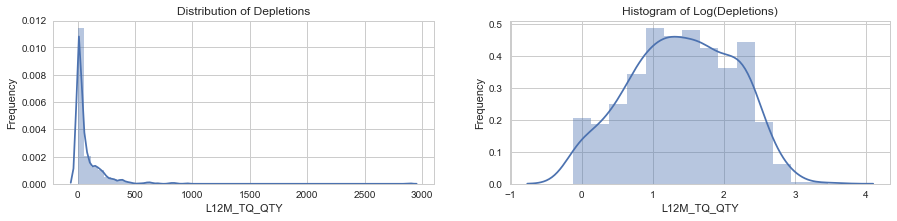

In [10]:
#Distribution of Depletions
f, axes = plt.subplots(1,2, figsize=(15, 3))
plt.subplot(1,2,2)
plt.title('Histogram of Log(Depletions)')
sns.distplot(np.log10(StoresON['L12M_TY_QTY'].values))
plt.xlabel('L12M_TQ_QTY')
plt.ylabel('Frequency')

plt.subplot(1,2,1)
plt.title('Distribution of Depletions')
sns.distplot(StoresON['L12M_TY_QTY'])
plt.xlabel('L12M_TQ_QTY')
plt.ylabel('Frequency')

In [11]:
#Binarize function
def binarize(dataframe , column):
    dataframe = pd.concat([dataframe ,pd.get_dummies(dataframe[column] , prefix = ['B_'+c for c in column])] , axis = 1)
    return(dataframe)

In [12]:
StoresON.columns

Index(['STORE_CD', 'L12M_TY_QTY', 'CHANNEL_DSC', 'SUBCHANNEL_DSC',
       'FOOD_TYPE_GROUP_DSC', 'INDUSTRY_VOL_DSC', 'CHAIN_IND_FLG',
       'FRANCHISE_FLG', 'WINE_FLG', 'LIQUOR_FLG', 'WHITE_POP_PCT',
       'BLACK_POP_PCT', 'ASIAN_POP_PCT', 'HISP_POP_PCT',
       'LEAST_ACC_HISP_POP_PCT', 'BI_CULTURAL_HISP_POP_PCT',
       'MOST_ACC_HISP_POP_PCT', 'OTHER_POP_PCT', 'INCOME_POP_L10_PCT',
       'INCOME_POP_1020_PCT', 'INCOME_POP_2030_PCT', 'INCOME_POP_3040_PCT',
       'INCOME_POP_4050_PCT', 'INCOME_POP_5075_PCT', 'INCOME_POP_75100_PCT',
       'INCOME_POP_G100_PCT', 'MALE_POP_2124_PCT', 'MALE_POP_2534_PCT',
       'MALE_POP_3544_PCT', 'MALE_POP_4554_PCT', 'MALE_POP_5564_PCT',
       'MALE_POP_6574_PCT', 'MALE_POP_75_PCT', 'FEMALE_POP_2124_PCT',
       'FEMALE_POP_2534_PCT', 'FEMALE_POP_3544_PCT', 'FEMALE_POP_4554_PCT',
       'FEMALE_POP_5564_PCT', 'FEMALE_POP_6574_PCT', 'FEMALE_POP_75_PCT'],
      dtype='object')

In [13]:
#Get Dummies
DummiesColumnsON = ['CHANNEL_DSC','SUBCHANNEL_DSC','FOOD_TYPE_GROUP_DSC','INDUSTRY_VOL_DSC']
StoresC_ON = binarize(StoresON, DummiesColumnsON)

#Normalize Depletions using Min-Max method
scaler = MinMaxScaler() 
StoresC_ON['NORM_L12M_TY_QTY'] = scaler.fit_transform(StoresON['L12M_TY_QTY'].values.reshape(-1,1)) 


In [14]:
# prepare data to fit model
X_labels_ON = [c for c in StoresC_ON.columns if c not in ['CHANNEL_DSC','SUBCHANNEL_DSC','FOOD_TYPE_GROUP_DSC','INDUSTRY_VOL_DSC',
                                                     'STORE_CD','L12M_TY_QTY']]
X_ON = StoresC_ON.loc[:,X_labels_ON]

In [15]:
X_ON.head()

,CHAIN_IND_FLG,FRANCHISE_FLG,WINE_FLG,LIQUOR_FLG,WHITE_POP_PCT,BLACK_POP_PCT,ASIAN_POP_PCT,HISP_POP_PCT,LEAST_ACC_HISP_POP_PCT,BI_CULTURAL_HISP_POP_PCT,...,B_FOOD_TYPE_GROUP_DSC_OTHER,B_FOOD_TYPE_GROUP_DSC_PIZZA,B_FOOD_TYPE_GROUP_DSC_SEAFOOD,B_FOOD_TYPE_GROUP_DSC_SMALL FOOD,B_FOOD_TYPE_GROUP_DSC_STEAK,B_FOOD_TYPE_GROUP_DSC_VARIED MENU,B_INDUSTRY_VOL_DSC_LOWEST 20% ON/ LOWEST 20% OFF,B_INDUSTRY_VOL_DSC_MID 30% ON/ MID 60% OFF,B_INDUSTRY_VOL_DSC_TOP 50% ON/ TOP 20% OFF,NORM_L12M_TY_QTY
0,False,False,False,False,0.9009,0.0147,0.0065,0.0529,0.0100,0.0125,...,1,0,0,0,0,0,1,0,0,0.001124
1,False,False,True,True,0.7495,0.0968,0.0631,0.0668,0.0133,0.0179,...,0,0,0,0,0,1,0,0,1,0.012368
2,False,False,False,False,0.8433,0.0436,0.0080,0.0510,0.0101,0.0161,...,1,0,0,0,0,0,0,0,1,0.001470
3,False,False,True,True,0.9453,0.0098,0.0035,0.0202,0.0043,0.0064,...,1,0,0,0,0,0,0,1,0,0.000432
4,True,False,True,True,0.7901,0.0996,0.0231,0.0655,0.0116,0.0200,...,0,0,0,0,0,0,0,0,1,0.040554


### Clustering

#### Choose number of Clusters

In [16]:
#Tunned Elbow Method ON
K = range(1, 20)
meandistortions = []
for k in K:
    kmeans = KMeans(n_clusters=k, n_jobs= -2)
    kmeans.fit(X_ON)
    meandistortions.append(sum(np.min(cdist(X_ON, kmeans.cluster_centers_, 'euclidean'), axis=1)) / X_ON.shape[0])

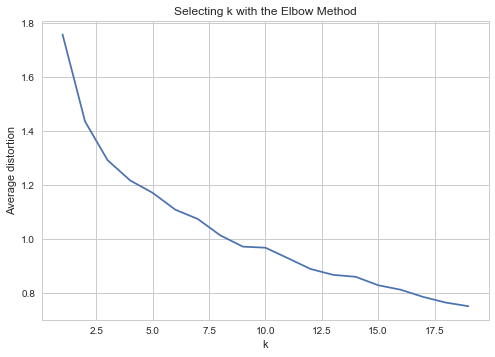

In [17]:
plt.plot(K, meandistortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Average distortion')
plt.title('Selecting k with the Elbow Method')
plt.show()

In [18]:
#Silhouette_score
results = []
NumberClusters = range(2,12,1)
for k in NumberClusters:
    kmeans_model = cluster.KMeans(n_clusters=k, random_state=1, n_jobs = -2).fit(X_ON)
    labels = kmeans_model.labels_
    score = metrics.silhouette_score(X_ON, labels, metric='euclidean')
    results.append((k,score))

Clustering_Score = pd.DataFrame(data=results,columns=['NumberOfClusters','silhouette_score'])
Clustering_Score

,NumberOfClusters,silhouette_score
0,2,0.306309
1,3,0.279501
2,4,0.282943
3,5,0.255370
4,6,0.257262
5,7,0.264969
6,8,0.256073
7,9,0.289801
8,10,0.303195
9,11,0.289574


In [19]:
#Cluster the Data ON
kmeans_model = cluster.KMeans(n_clusters=4, random_state=1, n_jobs = -2).fit(X_ON)
labels = kmeans_model.labels_

In [20]:
#Assign Cluster to Data
StoresON['CLUSTER'] = labels

In [21]:
StoresON.head()

,STORE_CD,L12M_TY_QTY,CHANNEL_DSC,SUBCHANNEL_DSC,FOOD_TYPE_GROUP_DSC,INDUSTRY_VOL_DSC,CHAIN_IND_FLG,FRANCHISE_FLG,WINE_FLG,LIQUOR_FLG,...,MALE_POP_6574_PCT,MALE_POP_75_PCT,FEMALE_POP_2124_PCT,FEMALE_POP_2534_PCT,FEMALE_POP_3544_PCT,FEMALE_POP_4554_PCT,FEMALE_POP_5564_PCT,FEMALE_POP_6574_PCT,FEMALE_POP_75_PCT,CLUSTER
0,101914477,4.000,BAR/NIGHTCLUB,NEIGHBORHOOD BAR,OTHER,LOWEST 20% ON/ LOWEST 20% OFF,False,False,False,False,...,0.0415,0.0285,0.0251,0.0676,0.0624,0.0578,0.0648,0.0460,0.0433,1
1,103707016,36.500,BAR/NIGHTCLUB,NEIGHBORHOOD BAR,VARIED MENU,TOP 50% ON/ TOP 20% OFF,False,False,True,True,...,0.0405,0.0228,0.0268,0.0641,0.0622,0.0644,0.0676,0.0435,0.0318,1
2,101930302,5.000,BAR/NIGHTCLUB,NEIGHBORHOOD BAR,OTHER,TOP 50% ON/ TOP 20% OFF,False,False,False,False,...,0.0519,0.0328,0.0224,0.0561,0.0551,0.0613,0.0715,0.0577,0.0472,1
3,101943225,2.000,BAR/NIGHTCLUB,NEIGHBORHOOD BAR,OTHER,MID 30% ON/ MID 60% OFF,False,False,True,True,...,0.0435,0.0283,0.0223,0.0527,0.0614,0.0694,0.0696,0.0473,0.0435,1
4,107487797,117.972,BAR/NIGHTCLUB,SPORTS BAR,AMERICAN,TOP 50% ON/ TOP 20% OFF,True,False,True,True,...,0.0414,0.0207,0.0230,0.0575,0.0688,0.0657,0.0663,0.0462,0.0314,1


### Regression Analysis

In [22]:
#Merge Class with StoreON Data for regression
RegressionDataON = pd.merge(StoresON, StoresClass, left_on='STORE_CD', right_on="RTL_STORE_CD", how="left")
RegressionDataON.loc[RegressionDataON['BEERTYPE'].isnull(),"BEERTYPE"] = "LowPoint"

In [23]:
RegressionDataON.tail()

,STORE_CD,L12M_TY_QTY,CHANNEL_DSC,SUBCHANNEL_DSC,FOOD_TYPE_GROUP_DSC,INDUSTRY_VOL_DSC,CHAIN_IND_FLG,FRANCHISE_FLG,WINE_FLG,LIQUOR_FLG,...,FEMALE_POP_2124_PCT,FEMALE_POP_2534_PCT,FEMALE_POP_3544_PCT,FEMALE_POP_4554_PCT,FEMALE_POP_5564_PCT,FEMALE_POP_6574_PCT,FEMALE_POP_75_PCT,CLUSTER,RTL_STORE_CD,BEERTYPE
622,103997048,2.0000,BAR/NIGHTCLUB,NEIGHBORHOOD BAR,OTHER,MID 30% ON/ MID 60% OFF,False,False,True,True,...,0.0193,0.0527,0.0524,0.0590,0.0916,0.0578,0.0713,1,NaN,LowPoint
623,201737465,48.7222,BAR/NIGHTCLUB,NEIGHBORHOOD BAR,OTHER,TOP 50% ON/ TOP 20% OFF,False,False,True,True,...,0.0226,0.0713,0.0617,0.0590,0.0737,0.0592,0.0550,1,201737465,NonLowPoint
624,107473689,27.0832,BAR/NIGHTCLUB,CASUAL NIGHTCLUB,OTHER,TOP 50% ON/ TOP 20% OFF,False,False,True,True,...,0.0255,0.0738,0.0627,0.0578,0.0622,0.0417,0.0325,1,107473689,NonLowPoint
625,301767732,21.0000,DINING,CASUAL DINING,VARIED MENU,LOWEST 20% ON/ LOWEST 20% OFF,False,False,True,True,...,0.0257,0.0667,0.0547,0.0599,0.0661,0.0473,0.0441,0,NaN,LowPoint
626,107393252,5.0000,DINING,CASUAL DINING,VARIED MENU,LOWEST 20% ON/ LOWEST 20% OFF,False,False,False,False,...,0.0205,0.0447,0.0531,0.0623,0.0679,0.0491,0.0458,0,NaN,LowPoint


In [24]:
len(RegressionDataON)

627

### Regression controlling for Cluster

In [25]:
#Regression ON Premise
modON = smf.ols(formula='np.log(L12M_TY_QTY) ~ C(BEERTYPE) + C(CLUSTER)', data=RegressionDataON)
print(modON.fit().summary())

                             OLS Regression Results                            
Dep. Variable:     np.log(L12M_TY_QTY)   R-squared:                       0.230
Model:                             OLS   Adj. R-squared:                  0.225
Method:                  Least Squares   F-statistic:                     46.32
Date:                 Thu, 29 Jun 2017   Prob (F-statistic):           4.41e-34
Time:                         15:10:24   Log-Likelihood:                -1133.0
No. Observations:                  627   AIC:                             2276.
Df Residuals:                      622   BIC:                             2298.
Df Model:                            4                                         
Covariance Type:             nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept 

### Analysis of the Clusters

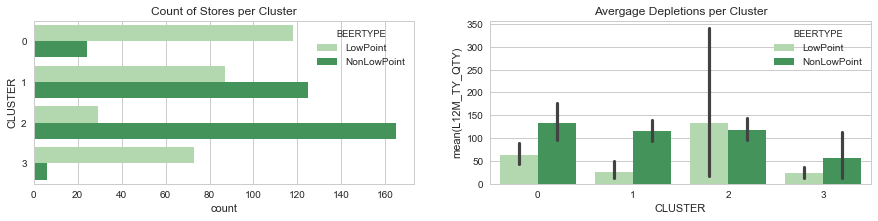

In [26]:
f, axes = plt.subplots(1,2, figsize=(15, 3))
plt.subplot(1,2,1)
plt.title("Count of Stores per Cluster")
sns.countplot(y="CLUSTER", hue= "BEERTYPE", data=RegressionDataON, palette="Greens");

plt.subplot(1,2,2)
plt.title("Avergage Depletions per Cluster")
sns.barplot(x="CLUSTER", y="L12M_TY_QTY", hue="BEERTYPE", data=RegressionDataON, palette="Greens");

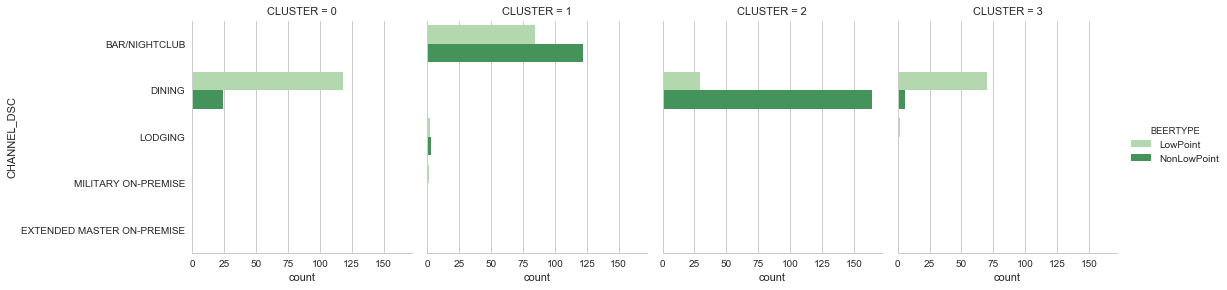

In [27]:
sns.factorplot(y="CHANNEL_DSC", hue="BEERTYPE",
               col="CLUSTER", data=RegressionDataON, kind="count", palette="Greens");

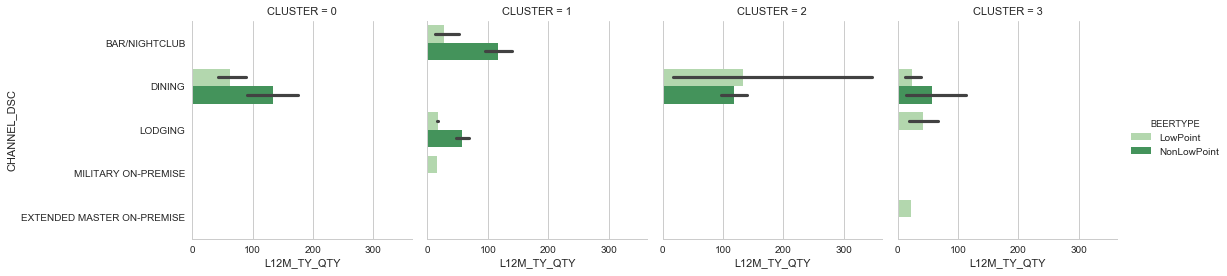

In [28]:
sns.factorplot(x='L12M_TY_QTY' ,y="CHANNEL_DSC", hue="BEERTYPE",
               col="CLUSTER", data=RegressionDataON, kind="bar", palette="Greens");

### Regression Based on Selected Cluster

#### Cluster 1

In [29]:
mod2ON = smf.ols(formula='np.log(L12M_TY_QTY) ~ C(BEERTYPE)', data=RegressionDataON.loc[RegressionDataON["CLUSTER"]==1,:])
print(mod2ON.fit().summary())

                             OLS Regression Results                            
Dep. Variable:     np.log(L12M_TY_QTY)   R-squared:                       0.322
Model:                             OLS   Adj. R-squared:                  0.319
Method:                  Least Squares   F-statistic:                     99.80
Date:                 Thu, 29 Jun 2017   Prob (F-statistic):           1.78e-19
Time:                         15:10:27   Log-Likelihood:                -373.86
No. Observations:                  212   AIC:                             751.7
Df Residuals:                      210   BIC:                             758.4
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept 

In [30]:
mod2ON = smf.ols(formula='np.log(L12M_TY_QTY) ~ C(BEERTYPE)', data=RegressionDataON.loc[RegressionDataON["CLUSTER"]==0,:])
print(mod2ON.fit().summary())

                             OLS Regression Results                            
Dep. Variable:     np.log(L12M_TY_QTY)   R-squared:                       0.125
Model:                             OLS   Adj. R-squared:                  0.118
Method:                  Least Squares   F-statistic:                     19.95
Date:                 Thu, 29 Jun 2017   Prob (F-statistic):           1.62e-05
Time:                         15:10:27   Log-Likelihood:                -255.56
No. Observations:                  142   AIC:                             515.1
Df Residuals:                      140   BIC:                             521.0
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept 

## OFF PREMISE ANALYSIS

### Data Preprocessing

##### Exploratory Analysis of the columns

In [31]:
StoresOFF.columns

Index(['STORE_CD', 'L12M_TY_QTY', 'PREMISE_TYPE_DSC', 'CHANNEL_DSC',
       'SUBCHANNEL_DSC', 'FOOD_TYPE_GROUP_DSC', 'INDUSTRY_VOL_DSC',
       'CHAIN_IND_FLG', 'FRANCHISE_FLG', 'BEER_FLG', 'WINE_FLG', 'LIQUOR_FLG',
       'FINE_WINE_FLG', 'WHITE_POP_PCT', 'BLACK_POP_PCT', 'ASIAN_POP_PCT',
       'HISP_POP_PCT', 'LEAST_ACC_HISP_POP_PCT', 'BI_CULTURAL_HISP_POP_PCT',
       'MOST_ACC_HISP_POP_PCT', 'OTHER_POP_PCT', 'INCOME_POP_L10_PCT',
       'INCOME_POP_1020_PCT', 'INCOME_POP_2030_PCT', 'INCOME_POP_3040_PCT',
       'INCOME_POP_4050_PCT', 'INCOME_POP_5075_PCT', 'INCOME_POP_75100_PCT',
       'INCOME_POP_G100_PCT', 'MALE_POP_2124_PCT', 'MALE_POP_2534_PCT',
       'MALE_POP_3544_PCT', 'MALE_POP_4554_PCT', 'MALE_POP_5564_PCT',
       'MALE_POP_6574_PCT', 'MALE_POP_75_PCT', 'FEMALE_POP_2124_PCT',
       'FEMALE_POP_2534_PCT', 'FEMALE_POP_3544_PCT', 'FEMALE_POP_4554_PCT',
       'FEMALE_POP_5564_PCT', 'FEMALE_POP_6574_PCT', 'FEMALE_POP_75_PCT'],
      dtype='object')

In [32]:
len(StoresOFF.columns)

43

In [33]:
for col in StoresOFF.columns:
    print(StoresOFF[col].describe())

count          1957
unique         1957
top       100321117
freq              1
Name: STORE_CD, dtype: object
count     1957.000000
mean       588.284411
std       1503.672089
min          1.000000
25%         23.000000
50%        124.000000
75%        515.250000
max      29712.999500
Name: L12M_TY_QTY, dtype: float64
count            1957
unique              1
top       OFF PREMISE
freq             1957
Name: PREMISE_TYPE_DSC, dtype: object
count                  1957
unique                    8
top       CONVENIENCE STORE
freq                    832
Name: CHANNEL_DSC, dtype: object
count                         1957
unique                          18
top       CONVENTIONAL CONVENIENCE
freq                           829
Name: SUBCHANNEL_DSC, dtype: object
count      1957
unique        1
top       OTHER
freq       1957
Name: FOOD_TYPE_GROUP_DSC, dtype: object
count                              1957
unique                                3
top       LOWEST 20% ON/ LOWEST 20% OFF
freq    

In [34]:
#Remove Not Necessary Columns
del StoresOFF['PREMISE_TYPE_DSC'] #Unique
del StoresOFF['FOOD_TYPE_GROUP_DSC'] #Unique
del StoresOFF['BEER_FLG'] # No Variance
del StoresOFF['FINE_WINE_FLG'] # No Variance


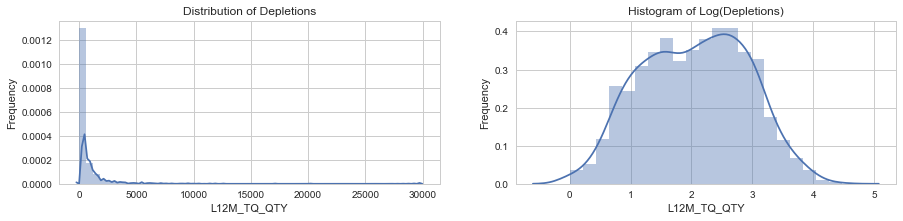

In [35]:
#Distribution of Depletions
f, axes = plt.subplots(1,2, figsize=(15, 3))
plt.subplot(1,2,2)
plt.title('Histogram of Log(Depletions)')
sns.distplot(np.log10(StoresOFF['L12M_TY_QTY'].values))
plt.xlabel('L12M_TQ_QTY')
plt.ylabel('Frequency')

plt.subplot(1,2,1)
plt.title('Distribution of Depletions')
sns.distplot(StoresOFF['L12M_TY_QTY'])
plt.xlabel('L12M_TQ_QTY')
plt.ylabel('Frequency')

In [36]:
StoresOFF.columns

Index(['STORE_CD', 'L12M_TY_QTY', 'CHANNEL_DSC', 'SUBCHANNEL_DSC',
       'INDUSTRY_VOL_DSC', 'CHAIN_IND_FLG', 'FRANCHISE_FLG', 'WINE_FLG',
       'LIQUOR_FLG', 'WHITE_POP_PCT', 'BLACK_POP_PCT', 'ASIAN_POP_PCT',
       'HISP_POP_PCT', 'LEAST_ACC_HISP_POP_PCT', 'BI_CULTURAL_HISP_POP_PCT',
       'MOST_ACC_HISP_POP_PCT', 'OTHER_POP_PCT', 'INCOME_POP_L10_PCT',
       'INCOME_POP_1020_PCT', 'INCOME_POP_2030_PCT', 'INCOME_POP_3040_PCT',
       'INCOME_POP_4050_PCT', 'INCOME_POP_5075_PCT', 'INCOME_POP_75100_PCT',
       'INCOME_POP_G100_PCT', 'MALE_POP_2124_PCT', 'MALE_POP_2534_PCT',
       'MALE_POP_3544_PCT', 'MALE_POP_4554_PCT', 'MALE_POP_5564_PCT',
       'MALE_POP_6574_PCT', 'MALE_POP_75_PCT', 'FEMALE_POP_2124_PCT',
       'FEMALE_POP_2534_PCT', 'FEMALE_POP_3544_PCT', 'FEMALE_POP_4554_PCT',
       'FEMALE_POP_5564_PCT', 'FEMALE_POP_6574_PCT', 'FEMALE_POP_75_PCT'],
      dtype='object')

In [37]:
#Get Dummies
DummiesColumnsOFF = ['CHANNEL_DSC','SUBCHANNEL_DSC','INDUSTRY_VOL_DSC']
StoresC_OFF = binarize(StoresOFF, DummiesColumnsOFF)

#Normalize Depletions using Min-Max method
scaler = MinMaxScaler() 
StoresC_OFF['NORM_L12M_TY_QTY'] = scaler.fit_transform(StoresOFF['L12M_TY_QTY'].values.reshape(-1,1)) 


In [38]:
# prepare data to fit model
X_labels_OFF = [c for c in StoresC_OFF.columns if c not in ['CHANNEL_DSC','SUBCHANNEL_DSC','INDUSTRY_VOL_DSC',
                                                     'STORE_CD','L12M_TY_QTY']]
X_OFF = StoresC_OFF.loc[:,X_labels_OFF]

In [39]:
X_OFF.head()

,CHAIN_IND_FLG,FRANCHISE_FLG,WINE_FLG,LIQUOR_FLG,WHITE_POP_PCT,BLACK_POP_PCT,ASIAN_POP_PCT,HISP_POP_PCT,LEAST_ACC_HISP_POP_PCT,BI_CULTURAL_HISP_POP_PCT,...,B_SUBCHANNEL_DSC_SUPERCENTER,B_SUBCHANNEL_DSC_SUPERETTE,B_SUBCHANNEL_DSC_SUPERMARKET-CONVENTIONAL,B_SUBCHANNEL_DSC_SUPERMARKET-LIMITED ASSORTMENT,B_SUBCHANNEL_DSC_SUPERMARKET-NATURAL/GOURMET FOODS,B_SUBCHANNEL_DSC_WINE SPECIALTY STORE,B_INDUSTRY_VOL_DSC_LOWEST 20% ON/ LOWEST 20% OFF,B_INDUSTRY_VOL_DSC_MID 30% ON/ MID 60% OFF,B_INDUSTRY_VOL_DSC_TOP 50% ON/ TOP 20% OFF,NORM_L12M_TY_QTY
0,False,False,True,True,0.9437,0.0103,0.0081,0.0195,0.0041,0.0061,...,0,0,0,0,0,0,0,0,1,0.002474
1,False,False,True,True,0.8233,0.0051,0.0065,0.1577,0.0274,0.0505,...,0,0,0,0,0,0,0,0,1,0.010442
2,False,False,True,True,0.7785,0.0523,0.0719,0.0742,0.0117,0.0222,...,0,0,0,0,0,0,0,0,1,0.020657
3,True,False,False,False,0.6504,0.1406,0.0332,0.1328,0.0238,0.0385,...,0,0,0,0,0,0,1,0,0,0.001346
4,False,False,True,True,0.9537,0.0015,0.0010,0.0150,0.0029,0.0039,...,0,0,0,0,0,0,0,0,1,0.004182


### Clustering

#### Choose number of Clusters

In [40]:
#Tunned Elbow Method OFF
K = range(1, 20)
meandistortions = []
for k in K:
    kmeans = KMeans(n_clusters=k, n_jobs= -2)
    kmeans.fit(X_OFF)
    meandistortions.append(sum(np.min(cdist(X_OFF, kmeans.cluster_centers_, 'euclidean'), axis=1)) / X_OFF.shape[0])

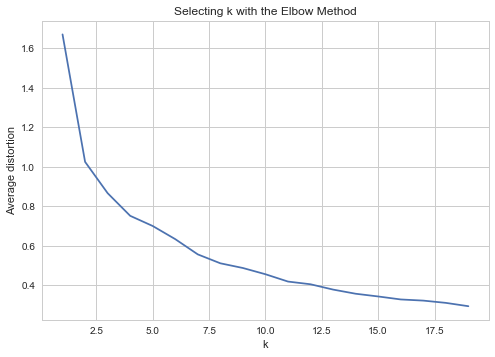

In [41]:
plt.plot(K, meandistortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Average distortion')
plt.title('Selecting k with the Elbow Method')
plt.show()

In [42]:
#Silhouette_score
results = []
NumberClusters = range(2,12,1)
for k in NumberClusters:
    kmeans_model = cluster.KMeans(n_clusters=k, random_state=1, n_jobs = -2).fit(X_OFF)
    labels = kmeans_model.labels_
    score = metrics.silhouette_score(X_OFF, labels, metric='euclidean')
    results.append((k,score))

Clustering_Score = pd.DataFrame(data=results,columns=['NumberOfClusters','silhouette_score'])
Clustering_Score

,NumberOfClusters,silhouette_score
0,2,0.519901
1,3,0.533786
2,4,0.520731
3,5,0.552142
4,6,0.531447
5,7,0.542286
6,8,0.546306
7,9,0.566513
8,10,0.592733
9,11,0.610873


In [43]:
#Cluster the Data OFF
kmeans_model = cluster.KMeans(n_clusters=5, random_state=1, n_jobs = -2).fit(X_OFF)
labels = kmeans_model.labels_

In [44]:
#Assign Cluster to Data
StoresOFF['CLUSTER'] = labels

In [45]:
StoresOFF.head()

,STORE_CD,L12M_TY_QTY,CHANNEL_DSC,SUBCHANNEL_DSC,INDUSTRY_VOL_DSC,CHAIN_IND_FLG,FRANCHISE_FLG,WINE_FLG,LIQUOR_FLG,WHITE_POP_PCT,...,MALE_POP_6574_PCT,MALE_POP_75_PCT,FEMALE_POP_2124_PCT,FEMALE_POP_2534_PCT,FEMALE_POP_3544_PCT,FEMALE_POP_4554_PCT,FEMALE_POP_5564_PCT,FEMALE_POP_6574_PCT,FEMALE_POP_75_PCT,CLUSTER
0,107027552,74.5000,LIQUOR,CONVENTIONAL LIQUOR,TOP 50% ON/ TOP 20% OFF,False,False,True,True,0.9437,...,0.0527,0.0431,0.0231,0.0486,0.0518,0.0589,0.0753,0.0581,0.0576,1
1,201650423,311.2502,LIQUOR,CONVENTIONAL LIQUOR,TOP 50% ON/ TOP 20% OFF,False,False,True,True,0.8233,...,0.0475,0.0307,0.0202,0.0463,0.0540,0.0624,0.0649,0.0459,0.0381,1
2,100766228,614.7500,LIQUOR,CONVENTIONAL LIQUOR,TOP 50% ON/ TOP 20% OFF,False,False,True,True,0.7785,...,0.0339,0.0198,0.0638,0.0854,0.0565,0.0429,0.0522,0.0372,0.0258,1
3,100558459,41.0000,CONVENIENCE STORE,CONVENTIONAL CONVENIENCE,LOWEST 20% ON/ LOWEST 20% OFF,True,False,False,False,0.6504,...,0.0252,0.0169,0.0491,0.0823,0.0514,0.0386,0.0413,0.0278,0.0231,3
4,101633764,125.2500,LIQUOR,CONVENTIONAL LIQUOR,TOP 50% ON/ TOP 20% OFF,False,False,True,True,0.9537,...,0.0633,0.0424,0.0199,0.0536,0.0463,0.0577,0.0840,0.0638,0.0577,1


### Regression Analysis

In [46]:
#Merge Class with StoreON Data for regression
RegressionDataOFF = pd.merge(StoresOFF, StoresClass, left_on='STORE_CD', right_on="RTL_STORE_CD", how="left")
RegressionDataOFF.loc[RegressionDataOFF['BEERTYPE'].isnull(),"BEERTYPE"] = "LowPoint"

In [47]:
RegressionDataOFF.tail()

,STORE_CD,L12M_TY_QTY,CHANNEL_DSC,SUBCHANNEL_DSC,INDUSTRY_VOL_DSC,CHAIN_IND_FLG,FRANCHISE_FLG,WINE_FLG,LIQUOR_FLG,WHITE_POP_PCT,...,FEMALE_POP_2124_PCT,FEMALE_POP_2534_PCT,FEMALE_POP_3544_PCT,FEMALE_POP_4554_PCT,FEMALE_POP_5564_PCT,FEMALE_POP_6574_PCT,FEMALE_POP_75_PCT,CLUSTER,RTL_STORE_CD,BEERTYPE
1952,101403851,71.5000,LIQUOR,CONVENTIONAL LIQUOR,TOP 50% ON/ TOP 20% OFF,False,False,True,True,0.9656,...,0.0202,0.0513,0.0495,0.0513,0.0818,0.0551,0.0584,1,101403851,NonLowPoint
1953,101529400,3.0000,CONVENIENCE STORE,CONVENTIONAL CONVENIENCE,LOWEST 20% ON/ LOWEST 20% OFF,False,False,False,False,0.6946,...,0.0347,0.0738,0.0577,0.0576,0.0618,0.0421,0.0407,3,NaN,LowPoint
1954,107368998,1916.3331,LIQUOR,CONVENTIONAL LIQUOR,TOP 50% ON/ TOP 20% OFF,False,False,True,True,0.5447,...,0.0252,0.0679,0.0597,0.0560,0.0585,0.0347,0.0318,1,107368998,NonLowPoint
1955,100743019,53.0000,CONVENIENCE STORE,CONVENTIONAL CONVENIENCE,LOWEST 20% ON/ LOWEST 20% OFF,False,False,False,False,0.6936,...,0.0625,0.0734,0.0562,0.0512,0.0522,0.0319,0.0245,3,NaN,LowPoint
1956,201974199,115.9161,LIQUOR,CONVENTIONAL LIQUOR,TOP 50% ON/ TOP 20% OFF,False,False,True,True,0.9679,...,0.0204,0.0459,0.0421,0.0572,0.0790,0.0684,0.0729,1,201974199,NonLowPoint


In [48]:
len(RegressionDataOFF)

1957

### Regression controlling for Cluster

In [49]:
#Regression ON Premise
modOFF = smf.ols(formula='np.log(L12M_TY_QTY) ~ C(BEERTYPE) + C(CLUSTER)', data=RegressionDataOFF)
print(modOFF.fit().summary())

                             OLS Regression Results                            
Dep. Variable:     np.log(L12M_TY_QTY)   R-squared:                       0.478
Model:                             OLS   Adj. R-squared:                  0.477
Method:                  Least Squares   F-statistic:                     357.6
Date:                 Thu, 29 Jun 2017   Prob (F-statistic):          2.07e-272
Time:                         15:11:19   Log-Likelihood:                -3491.6
No. Observations:                 1957   AIC:                             6995.
Df Residuals:                     1951   BIC:                             7029.
Df Model:                            5                                         
Covariance Type:             nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept 

### Analysis of the Clusters

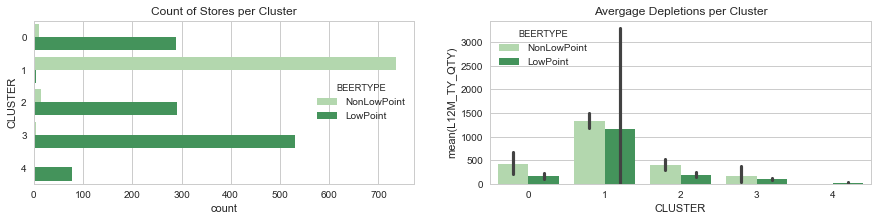

In [50]:
f, axes = plt.subplots(1,2, figsize=(15, 3))
plt.subplot(1,2,1)
plt.title("Count of Stores per Cluster")
sns.countplot(y="CLUSTER", hue= "BEERTYPE", data=RegressionDataOFF, palette="Greens");

plt.subplot(1,2,2)
plt.title("Avergage Depletions per Cluster")
sns.barplot(x="CLUSTER", y="L12M_TY_QTY", hue="BEERTYPE", data=RegressionDataOFF, palette="Greens");

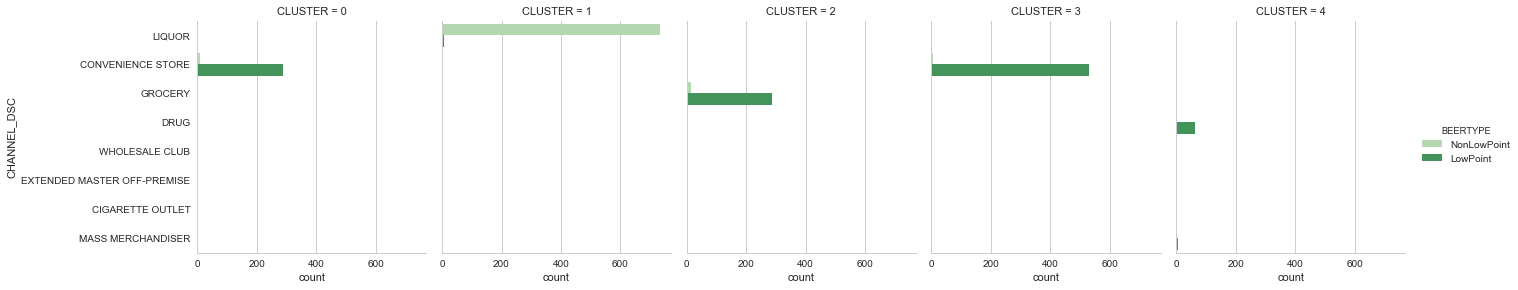

In [51]:
sns.factorplot(y="CHANNEL_DSC", hue="BEERTYPE",
               col="CLUSTER", data=RegressionDataOFF, kind="count", palette="Greens");

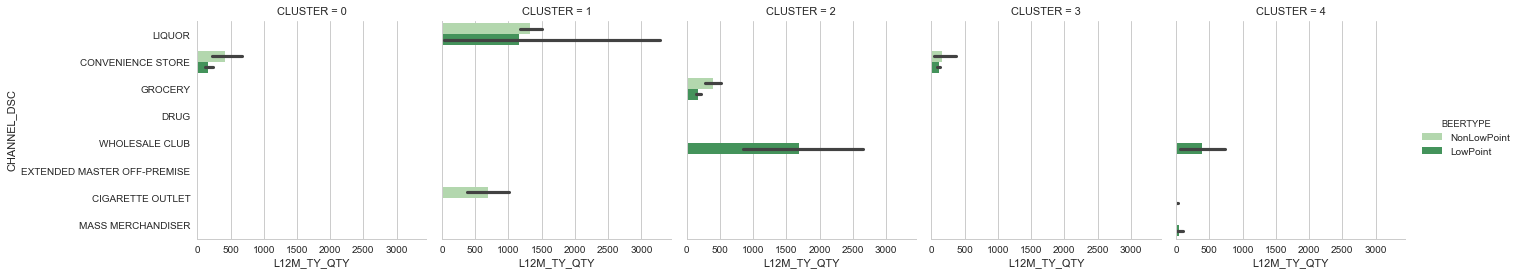

In [52]:
sns.factorplot(x='L12M_TY_QTY' ,y="CHANNEL_DSC", hue="BEERTYPE",
               col="CLUSTER", data=RegressionDataOFF, kind="bar", palette="Greens");

### Regression Based on Selected Cluster

#### Cluster 1

In [53]:
mod2OFF = smf.ols(formula='np.log(L12M_TY_QTY) ~ C(BEERTYPE)', data=RegressionDataOFF.loc[RegressionDataOFF["CLUSTER"]==0,:])
print(mod2OFF.fit().summary())

                             OLS Regression Results                            
Dep. Variable:     np.log(L12M_TY_QTY)   R-squared:                       0.048
Model:                             OLS   Adj. R-squared:                  0.045
Method:                  Least Squares   F-statistic:                     14.99
Date:                 Thu, 29 Jun 2017   Prob (F-statistic):           0.000133
Time:                         15:11:23   Log-Likelihood:                -561.53
No. Observations:                  299   AIC:                             1127.
Df Residuals:                      297   BIC:                             1134.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept 

In [54]:
mod2OFF = smf.ols(formula='np.log(L12M_TY_QTY) ~ C(BEERTYPE)', data=RegressionDataOFF.loc[RegressionDataOFF["CLUSTER"]==2,:])
print(mod2OFF.fit().summary())

                             OLS Regression Results                            
Dep. Variable:     np.log(L12M_TY_QTY)   R-squared:                       0.037
Model:                             OLS   Adj. R-squared:                  0.034
Method:                  Least Squares   F-statistic:                     11.79
Date:                 Thu, 29 Jun 2017   Prob (F-statistic):           0.000679
Time:                         15:11:23   Log-Likelihood:                -570.79
No. Observations:                  305   AIC:                             1146.
Df Residuals:                      303   BIC:                             1153.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept 